In [381]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_tabnet
import pickle
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
from pytorch_tabnet.tab_network import TabNetNoEmbeddings

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

from Syn_data.Gen_syn_data import DataGenerator
# from Syn_data import Gen_datasets, TestDataGenerator


In [579]:
file = os.path.join(os.getcwd(), "Syn_data/Datasets/N=500_p=60_d_random=40/data.pkl")
print(file)
with open(file, "rb") as input_file:
     test = pickle.load(input_file)

print(test)

c:\Users\hberg\Documents\School\Spring 2024\DL\Final\DLCausalOptimization\Syn_data/Datasets/N=500_p=60_d_random=40/data.pkl
         X100  X97       X45        X5       X17       X19  X79       X90  \
0    0.953674  0.0  3.599424 -1.601813 -1.065778  1.678513  0.0  0.320370   
1    0.622635  1.0  4.707627  1.092315 -0.910423 -1.218744  1.0  0.624516   
2    0.257182  1.0  4.188053  0.556145 -1.756460 -3.638971  0.0  0.982277   
3    0.438074  2.0  3.180013 -1.059830  0.065775  0.005560  1.0  0.276598   
4    0.828074  0.0  6.260810  0.536100  1.744836  6.724427  1.0  0.385101   
..        ...  ...       ...       ...       ...       ...  ...       ...   
495  0.429033  1.0  5.180727 -0.660780  0.164403  7.297957  3.0  0.874582   
496  0.530856  1.0  6.700534  1.215093  0.643555  4.001548  1.0  0.716684   
497  0.118589  1.0  3.647414  0.228198  0.497133 -4.127769  0.0  0.653219   
498  0.996889  1.0  2.627982  0.597150 -0.663639  1.347364  1.0  0.522663   
499  0.288679  1.0  1.099016 

In [580]:
info = os.path.join(os.getcwd(), "Syn_data/Datasets/N=500_p=60_d_random=40/dag_info.pkl")
print(info)
with open(info, "rb") as input_file:
     test_info = pickle.load(input_file)

print(test_info)

c:\Users\hberg\Documents\School\Spring 2024\DL\Final\DLCausalOptimization\Syn_data/Datasets/N=500_p=60_d_random=40/dag_info.pkl
{'adjacency_matrix': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'target': 79, 'relevant_nodes': [29, 96, 44, 3, 47, 11, 56, 58, 21, 83, 18, 4, 54, 73, 39, 41], 'irrelevant_nodes': [43, 99, 22, 71, 87, 50, 76, 88, 27, 30, 5, 55, 97, 68, 38, 15, 77, 89, 82, 14, 20, 10, 79, 60, 53, 12, 40, 19, 2, 85, 80, 72, 63, 32, 34, 59, 74, 78, 17, 23, 24, 86, 35, 94], 'random_nodes': [70, 66, 64, 92, 51, 42, 13, 49, 45, 98, 62, 84, 36, 25, 8, 16, 57, 33, 6, 67, 90, 93, 61, 52, 9, 31, 28, 75, 69, 7, 46, 81, 95, 48, 37, 65, 1, 26, 91, 0]}


In [581]:
relevant_nodes = test_info['relevant_nodes']
irrelevant_nodes = test_info['irrelevant_nodes']
random_nodes = test_info['random_nodes']
target_num = test_info['target']

In [582]:
max_col = len(test.columns) - 1
print(target_num)
col_list = list(test)
col_list[target_num], col_list[max_col] = col_list[max_col], col_list[target_num]
# test.columns = col_list
# print(test)
test = test[col_list]
print(test)


79
         X100  X97       X45        X5       X17       X19  X79       X90  \
0    0.953674  0.0  3.599424 -1.601813 -1.065778  1.678513  0.0  0.320370   
1    0.622635  1.0  4.707627  1.092315 -0.910423 -1.218744  1.0  0.624516   
2    0.257182  1.0  4.188053  0.556145 -1.756460 -3.638971  0.0  0.982277   
3    0.438074  2.0  3.180013 -1.059830  0.065775  0.005560  1.0  0.276598   
4    0.828074  0.0  6.260810  0.536100  1.744836  6.724427  1.0  0.385101   
..        ...  ...       ...       ...       ...       ...  ...       ...   
495  0.429033  1.0  5.180727 -0.660780  0.164403  7.297957  3.0  0.874582   
496  0.530856  1.0  6.700534  1.215093  0.643555  4.001548  1.0  0.716684   
497  0.118589  1.0  3.647414  0.228198  0.497133 -4.127769  0.0  0.653219   
498  0.996889  1.0  2.627982  0.597150 -0.663639  1.347364  1.0  0.522663   
499  0.288679  1.0  1.099016 -1.195809  0.605732 -8.576854  1.0  0.729164   

          X75       X85  ...       X81  X99  X64  X82       X60       X9

In [583]:
if max_col in irrelevant_nodes:
    irrelevant_nodes.remove(max_col)
else:
    if target_num in relevant_nodes:
        relevant_nodes.remove(target_num)
    elif target_num in random_nodes:
        random_nodes.remove(target_num)
    else:
        irrelevant_nodes.remove(target_num)
    relevant_nodes = [target_num if num == max_col else num for num in relevant_nodes]
    random_nodes = [target_num if num == max_col else num for num in random_nodes]

target_num = max_col
print(relevant_nodes)
print(irrelevant_nodes)
print(random_nodes)

[29, 96, 44, 3, 47, 11, 56, 58, 21, 83, 18, 4, 54, 73, 39, 41]
[43, 22, 71, 87, 50, 76, 88, 27, 30, 5, 55, 97, 68, 38, 15, 77, 89, 82, 14, 20, 10, 79, 60, 53, 12, 40, 19, 2, 85, 80, 72, 63, 32, 34, 59, 74, 78, 17, 23, 24, 86, 35, 94]
[70, 66, 64, 92, 51, 42, 13, 49, 45, 98, 62, 84, 36, 25, 8, 16, 57, 33, 6, 67, 90, 93, 61, 52, 9, 31, 28, 75, 69, 7, 46, 81, 95, 48, 37, 65, 1, 26, 91, 0]


In [273]:
print(test['T'])

0      0.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
495    0.0
496    1.0
497    1.0
498    0.0
499    0.0
Name: T, Length: 500, dtype: float64


In [584]:
train = test
target = 'T'
if "Set" not in train.columns:
    while True:
        train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))
        train_indices = train[train.Set=="train"].index
        valid_indices = train[train.Set=="valid"].index
        test_indices = train[train.Set=="test"].index
        
        y_train = train[target].values[train_indices]
        y_valid = train[target].values[valid_indices]
        y_test = train[target].values[test_indices]
        # print(len(y_valid))
        # print(y_valid)
        # print(len(y_test))
        # print(y_test)
        if (len(y_valid) > 2) and (len(y_test) > 2):
            if (not all(c == y_valid[0] for c in y_valid)) and (not all(c == y_test[0] for c in y_test)):
                break
            else:
                print("rerolling 2")
        else:
            print("rerolling")

# train_indices = train[train.Set=="train"].index
# valid_indices = train[train.Set=="valid"].index
# test_indices = train[train.Set=="test"].index

In [314]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

X97 7
X79 6
X98 2
X78 2
X73 2
X69 2
X94 2
X68 2
X65 2
X84 2
X77 6
X63 2
X62 6
X89 7
X88 7
X99 6
X64 2
X82 2
X70 2
T 2
Set 3


In [315]:
print(categorical_columns)
print(target)

['X97', 'X79', 'X98', 'X78', 'X73', 'X69', 'X94', 'X68', 'X65', 'X84', 'X77', 'X63', 'X62', 'X89', 'X88', 'X99', 'X64', 'X82', 'X70', 'T', 'Set']
T


In [316]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [317]:
print(features)
grouped_features = [relevant_nodes, irrelevant_nodes, random_nodes]
print(grouped_features)

['X100', 'X97', 'X45', 'X5', 'X17', 'X19', 'X79', 'X90', 'X75', 'X85', 'X33', 'X41', 'X39', 'X67', 'X31', 'X25', 'X76', 'X55', 'X16', 'X43', 'X32', 'X12', 'X3', 'X56', 'X57', 'X74', 'X98', 'X13', 'X87', 'X34', 'X14', 'X86', 'X50', 'X78', 'X51', 'X59', 'X73', 'X95', 'X24', 'X26', 'X42', 'X30', 'X66', 'X1', 'X37', 'X69', 'X91', 'X40', 'X94', 'X68', 'X8', 'X65', 'X84', 'X38', 'X18', 'X20', 'X9', 'X77', 'X44', 'X52', 'X36', 'X83', 'X71', 'X49', 'X63', 'X96', 'X62', 'X80', 'X23', 'X89', 'X61', 'X6', 'X48', 'X21', 'X53', 'X88', 'X10', 'X27', 'X54', 'X2', 'X47', 'X92', 'X29', 'X15', 'X72', 'X46', 'X58', 'X7', 'X11', 'X28', 'X81', 'X99', 'X64', 'X82', 'X60', 'X93', 'X4', 'X22', 'X70']
[[29, 96, 44, 3, 47, 11, 56, 58, 21, 83, 18, 4, 54, 73, 39, 41], [43, 22, 71, 87, 50, 76, 88, 27, 30, 5, 55, 97, 68, 38, 15, 77, 89, 82, 14, 20, 10, 79, 60, 53, 12, 40, 19, 2, 85, 80, 72, 63, 32, 34, 59, 74, 78, 17, 23, 24, 86, 35, 94], [70, 66, 64, 92, 51, 42, 13, 49, 45, 98, 62, 84, 36, 25, 8, 16, 57, 33, 6, 67

In [355]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":2,
                 "optimizer_fn":torch.optim.SGD,
                 "optimizer_params":dict(lr=1e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                     "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                #  "grouped_features" : grouped_features,
                }

clf = TabNetClassifier(**tabnet_params)

In [348]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [375]:
max_epochs = 500
aug = ClassificationSMOTE(p=0.2)

In [380]:
sparse_X_train = scipy.sparse.csr_matrix(X_train)  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(X_valid)  # Create a CSR matrix from X_valid
# print(y_train)
# print(y_valid)
# print(y_test)

# Fitting the model
clf.fit(
    X_train=sparse_X_train, y_train=y_train,
    eval_set=[(sparse_X_train, y_train), (sparse_X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=500,
    batch_size=64, virtual_batch_size=16,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug, #aug, None
    # loss_fn=torch.nn.functional.binary_cross_entropy_with_logits,
)
# clf.fit(X_train, y_train, max_epochs=100)

epoch 0  | loss: 0.82487 | train_auc: 0.59889 | valid_auc: 0.62097 |  0:00:00s
epoch 1  | loss: 0.81798 | train_auc: 0.56747 | valid_auc: 0.66487 |  0:00:00s
epoch 2  | loss: 0.84094 | train_auc: 0.60167 | valid_auc: 0.66219 |  0:00:01s
epoch 3  | loss: 0.85384 | train_auc: 0.57448 | valid_auc: 0.65233 |  0:00:01s
epoch 4  | loss: 0.80589 | train_auc: 0.57344 | valid_auc: 0.63889 |  0:00:02s
epoch 5  | loss: 0.78886 | train_auc: 0.56297 | valid_auc: 0.60125 |  0:00:02s
epoch 6  | loss: 0.88206 | train_auc: 0.5659  | valid_auc: 0.59409 |  0:00:03s
epoch 7  | loss: 0.78835 | train_auc: 0.53938 | valid_auc: 0.57527 |  0:00:03s
epoch 8  | loss: 0.80357 | train_auc: 0.5342  | valid_auc: 0.57437 |  0:00:04s
epoch 9  | loss: 0.86303 | train_auc: 0.52516 | valid_auc: 0.57796 |  0:00:04s
epoch 10 | loss: 0.83639 | train_auc: 0.53834 | valid_auc: 0.61022 |  0:00:05s
epoch 11 | loss: 0.8429  | train_auc: 0.53333 | valid_auc: 0.59409 |  0:00:05s
epoch 12 | loss: 0.77381 | train_auc: 0.53955 | vali

C:\Users\hberg\AppData\Roaming\Python\Python312\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [350]:
preds = clf.predict_proba(X_test)
print(preds)

[[5.2909219e-01 4.7090781e-01]
 [6.6717148e-01 3.3282852e-01]
 [4.8717770e-01 5.1282227e-01]
 [4.6703747e-01 5.3296256e-01]
 [5.8527488e-01 4.1472515e-01]
 [4.8169222e-01 5.1830775e-01]
 [5.0004750e-01 4.9995250e-01]
 [7.2355330e-01 2.7644667e-01]
 [5.9014130e-01 4.0985867e-01]
 [4.7650912e-01 5.2349091e-01]
 [5.3075665e-01 4.6924332e-01]
 [6.1866337e-01 3.8133657e-01]
 [8.6842006e-01 1.3157994e-01]
 [4.3899226e-01 5.6100768e-01]
 [4.8933920e-01 5.1066083e-01]
 [4.1175652e-01 5.8824348e-01]
 [4.8219937e-01 5.1780069e-01]
 [6.6700774e-01 3.3299229e-01]
 [5.5343539e-01 4.4656464e-01]
 [2.5054082e-01 7.4945915e-01]
 [5.1332623e-01 4.8667380e-01]
 [6.3242972e-01 3.6757028e-01]
 [6.4782077e-01 3.5217926e-01]
 [1.0000000e+00 1.2239598e-11]
 [4.4740596e-01 5.5259407e-01]
 [1.0000000e+00 6.8937660e-09]
 [5.6028020e-01 4.3971977e-01]
 [5.3104156e-01 4.6895841e-01]
 [5.2710778e-01 4.7289219e-01]
 [1.0000000e+00 0.0000000e+00]
 [4.8337242e-01 5.1662755e-01]
 [5.6999475e-01 4.3000522e-01]
 [6.2300

In [386]:
feature_importances = clf.feature_importances_
relevant = feature_importances[relevant_nodes]
irrelevant = feature_importances[irrelevant_nodes]
random = feature_importances[random_nodes]
print("Feature Importance Scores:", feature_importances)
print("Relevant feature score:", np.mean(relevant))
print("Irrelevant feature score:", np.mean(irrelevant))
print("Random feature score:", np.mean(random))

Feature Importance Scores: [0.00647709 0.00471571 0.01096102 0.008313   0.00650148 0.01372261
 0.00647425 0.00738504 0.00778727 0.00959866 0.01062974 0.0054891
 0.00586267 0.00806262 0.00966141 0.00729377 0.01238954 0.0146157
 0.01338086 0.02139792 0.01089359 0.0045723  0.00977383 0.01822672
 0.01167704 0.00665661 0.00789995 0.00977335 0.00836376 0.00930877
 0.00956716 0.00757745 0.00620715 0.00662536 0.00794263 0.01785955
 0.01019629 0.00998983 0.0096596  0.00605078 0.00915223 0.00742006
 0.00863567 0.01080442 0.00825809 0.0112354  0.02058532 0.0114679
 0.0090967  0.0068676  0.01059646 0.00576219 0.00525634 0.00711468
 0.00521146 0.01128189 0.01425752 0.00744525 0.00953285 0.00594139
 0.01692054 0.01090564 0.01197098 0.02550911 0.00698089 0.00993062
 0.01013586 0.01315653 0.01698877 0.00590983 0.00677223 0.00842293
 0.00727635 0.0117321  0.01124896 0.00651172 0.00884081 0.01229293
 0.01514465 0.00723329 0.01446474 0.00996631 0.01614721 0.00688042
 0.00760131 0.01091292 0.00613898 0.00

<Axes: >

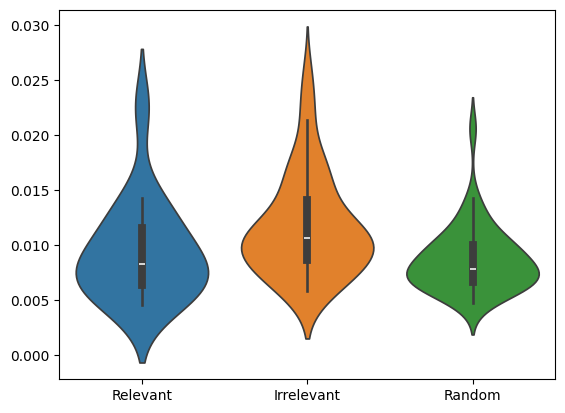

In [387]:
max_length = max(len(relevant), len(irrelevant), len(random))
relevant_padded = np.pad(relevant, (0, max_length - len(relevant)), mode='constant', constant_values=np.nan)
irrelevant_padded = np.pad(irrelevant, (0, max_length - len(irrelevant)), mode='constant', constant_values=np.nan)
random_padded = np.pad(random, (0, max_length - len(random)), mode='constant', constant_values=np.nan)
data_500_60 = pd.DataFrame({'Relevant': relevant_padded,
                            'Irrelevant': irrelevant_padded,
                            'Random': random_padded})
sns.violinplot(data=data_500_60)

In [388]:
preds_test = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds_test[:,1], y_true=y_test)

preds_train = clf.predict_proba(X_train)
train_auc = roc_auc_score(y_score=preds_train[:,1], y_true=y_train)

preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print("Train AUC score:", train_auc)
print("Validation AUC score:", valid_auc)
print("Test AUC score:", test_auc)

Train AUC score: 0.7151945054326408
Validation AUC score: 0.7840501792114696
Test AUC score: 0.6309677419354838


In [395]:
median = np.median(feature_importances)
false_negative = 0
false_positive_i = 0
false_positive_r = 0
for i in relevant:
    if i < median:
        false_negative += 1
for i in irrelevant:
    if i > median:
        false_positive_i += 1
for i in random:
    if i > median:
        false_positive_r += 1
print("False negative rate for relevant features:", false_negative / len(relevant_nodes))
print("False positive rate for irrelevant features:", false_positive_i / len(irrelevant_nodes))
print("False positive rate for random features:", false_positive_r / len(random_nodes))

False negative rate for relevant features: 0.5625
False positive rate for irrelevant features: 0.6976744186046512
False positive rate for random features: 0.325


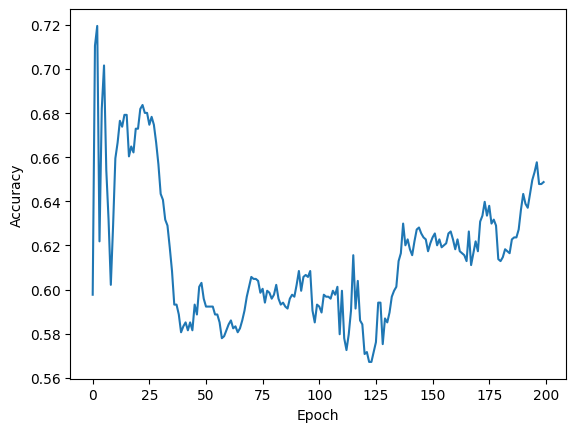

In [343]:
loss_history = clf.history['valid_auc']
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(loss_history)
